<a href="https://colab.research.google.com/github/charlesdgburns/NM_TinyRNN/blob/main/notebooks/nm_tinyrnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Let's use this as a learning notebook about different RNN architectures.
We want to start from scratch and get an idea of how different architectures work before fitting to some data.


We the fit these to sequential behavioural decision making later.


In [ ]:
## setup on google colab:

!git clone https://github.com/charlesdgburns/NM_TinyRNN.git

fatal: destination path 'NM_TinyRNN' already exists and is not an empty directory.


In [ ]:
# setup

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path


# Recurrent Neural Network (RNN)

The simplest of all recurrent architectures, which we think of as updating a hidden state $h_t$ using sensory inputs $x_{t-1}$ and recurrent inputs from the last hidden state $h_{t-1}$. Formally, this is described as a single discretised update:

$$ h_t = \tanh(W_{ih} x_{t-1} + b_{i} + W_{hh} h_{t-1} +b_{hh}) $$

where $W_{ih}$ are the weights from the input to the hidden state, $W_{hh}$ are the recurrent weights from the hidden state to itself, and we consider additional biases $b_{i}$ and $b_{hh}$.

In [ ]:
# let's do this later.

# Gated Recurrent Unit (GRU)

We are taking inspiration from the following blogpost:
https://medium.com/data-science/building-a-lstm-by-hand-on-pytorch-59c02a4ec091

**The information flow in a gated recurrent unit**

A gated recurrent unit has information flowing from the inputs $^{(1)}$ $x_{t-1}$  and the past hidden $h_{t-1}$, which is gated via 'reset' and 'update' gates $r_t$ and $z_t$ before giving the final output $h_t$. The update gate decides whether or not to overwrite a long-term memory with inputs, while the

The gated recurrent unit allows the recurrent unit to persist its state and ignore its inputs.


$$ r_t = \sigma(W_{ir}x_{t-1}+b_{ir}+W_{hr}h_{t-1}+b_{hr}) \qquad \text{(reset)}$$

$$ z_t = \sigma(W_{iz}x_{t-1}+b_{iz}+W_{hz}h_{t-1}+b_{hz}) \qquad\text{(update)}$$

$$ n_t = \tanh(W_{in}x_{t-1}+b_{in}+r_{t}\odot (W_{hn}h_{t-1}+b_{hn})) \qquad\text{(new)} $$

$$ h_t = (1-z_t)\odot n_t +z_t \odot h_{t-1} \qquad\text{(gated reccurent output)}$$

*footnotes*
(1): inputs at time $t$ is recent experience

Note that GRU's are markovian - their current state ($h_t$) can be determined entirely from its previous state ($h_{t-1}$) and inputs ($x_{t-1}$).

In [324]:
import torch
import torch.nn as nn
import math
import numpy as np

class ManualGRU(nn.Module):
  '''Manual GRU coded with gate_activations() to return gate activations '''
  def __init__(self,input_size,hidden_size):
    super().__init__() #init nn.Module
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.sigmoid = torch.nn.Sigmoid()
    self.tanh = torch.nn.Tanh()

    self.W_from_in = nn.Parameter(torch.Tensor(input_size, hidden_size*3))
    self.W_from_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size*3))
    self.bias = nn.Parameter(torch.Tensor(hidden_size*6))
    self.init_weights()

  def init_weights(self):
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
        weight.data.uniform_(-stdv, stdv)

  def forward(self, inputs, init_states = None):
    ''' inputs are a tensor of shape (batch_size, sequence_size, input_size)
        outputs are tensor of shape (batch_size, sequence_size, hidden_size)'''

    batch_size, sequence_size, _ = inputs.shape
    hidden_sequence = []
    if init_states is None:
      h_past = torch.zeros(batch_size, self.hidden_size).to(inputs.device) #(n_hidden,batch_size)
    else:
      h_past = init_states

    for t in range(sequence_size):
      x_past = inputs[:,t,:] #(n_batch,input_size)
      #for computational efficiency we do two matrix multiplications and then do indexing further down:
      from_input = x_past@self.W_from_in + self.bias[:3*self.hidden_size]
      from_input = from_input.view(batch_size,3, self.hidden_size) #(n_batch,3,n_hidden)
      from_hidden = h_past@self.W_from_h + self.bias[3*self.hidden_size:]
      from_hidden = from_hidden.view(batch_size, 3, self.hidden_size) #(n_batch,3, n_hidden)
      r_t = self.sigmoid(from_input[:,0]+from_hidden[:,0]) #(n_batch,n_hidden), ranging from 0 to 1
      z_t = self.sigmoid(from_input[:,1]+from_hidden[:,1]) #(n_batch,n_hidden), ranging from 0 to 1; must have n_hidden because it is multiplied with hidden_state later.
      n_t = self.tanh(from_input[:,2]+r_t*(from_hidden[:,2])).view(batch_size, self.hidden_size) #(n_batch,n_hidden)
      h_past = (1-z_t)*n_t + z_t*h_past #(n_batch,hidden_size) #NOTE h_past is tehnically h_t now, but in the next for-loop it will be h_past. ;)
      hidden_sequence.append(h_past.unsqueeze(0)) #appending (1,n_batch,n_hidden) to a big list.
    hidden_sequence = torch.cat(hidden_sequence, dim=0) #(n_sequence, n_batch, n_hidden) gather all inputs along the first dimenstion
    hidden_sequence = hidden_sequence.transpose(0, 1).contiguous() #reshape to batch first (n_batch,n_seq,n_hidden)
    return hidden_sequence, h_past #this is standard in Pytorch, to output sequence of hidden states alongside most recent hidden state.


test = ManualGRU(3, 2)
hidden_sequence, h_past = test(batch_inputs)

# Long-Short-Term-Memory

In [ ]:



class ManualLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz, device):
        super().__init__()
        self.device=device
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 6))
        self.init_weights()
        super().__init__()

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv).to(self.device)

    def forward(self, x,
                init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device),
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states

        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)


# NM-RNN

[Costacura et al. (2024)](https://openreview.net/pdf?id=HbIBqn3grD) introduced NM-RNNs to bridge a gap between more standard RNNs today and biophysical models.

Here we rewrite the equations (1) to (4) in Costacura et al. (2024) more similarly to the standard RNN notation above.

We have inputs $x_{t-1}$ and our past hidden state $h_{t-1}$ which we want to integrate to get a new hidden state $h_t$. However, we want to selectively change (by a gain) the weights of our recurrent network depending on a neuromodulation signal $s(z(t))$.

We therefore have a coupled network system, starting from a subnetwork state $z(t)$. In discretised terms:
$$ \tau_{z}  z_t = W_{zz} \phi(z_t)+W_{iz} x_{t-1} \qquad (1) $$

$$ \tau_{x} h_{t-1} = W_x(z_t)\cdot\phi(h_{t-1})+W_{ih} \qquad (2)$$

$$s(z(t)) = \sigma(W_s z_t+ b_s) \qquad W_x(z_t)=\sum_{k=1}^K s_k(z_t)\mathcal{l}_k r_k^T \qquad (4)$$

Note that instead of a low-rank recurrent weight component, we want a tiny RNN, so we could modulating the weights associated with a given unit. Now the 'dynamic modes' are not the low ranks of a large network, but the activity of single units.

In [ ]:

class ManualNMRNN(nn.Module):
  def __init__(self,input_size,hidden_size, batch_first = False):
    self.sigmoid = torch.nn.Sigmoid()
    self.tanh = torch.nn.Tanh()

    self.W_from_in = nn.Parameter(torch.Tensor(input_size, hidden_size*2))
    self.W_from_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size*3))
    self.bias = nn.Parameter(torch.Tensor(hidden_size*6))
    self.init_weights()
    super().__init__() #init nn.Module

  def init_weights(self):
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
        weight.data.uniform_(-stdv, stdv)
  def forward(self, inputs, init_states = None):
    ''' inputs are a tensor of shape (batch_size, sequence_size, input_size)
        outputs are tensor of shape (batch_size, sequence_size, hidden_size)'''

    batch_size, sequence_size, _ = inputs.size
    hidden_sequence = []
    if init_states is None:
      h_past = torch.zeros(batch_size, self.hidden_size).to(inputs.device)
    else:
      h_past = init_states

    for t in range(sequence_size):
      x_past = inputs[:,t,:] #(n_batch,input_size)
      #for computational efficiency we do two matrix multiplications and then do indexing further down:
      from_input = x_past@self.W_from_in + self.bias[:3]  #(n_batch,n_hidden)
      from_hidden = h_past@self.W_from_h + self.bias[3:]  #(n_batch,n_hidden)

      r_t =self.sigmoid(from_input[0]+from_hidden[0]) #(n_batch,n_hidden), ranging from 0 to 1
      z_t = self.sigmoid(from_input[1]+from_hidden[1]) #(n_batch,n_hidden), ranging from 0 to 1
      n_t = self.tanh(from_input[2]+r_t*(from_hidden[2])) #(n_batch,n_hidden)
      h_past = (1-z_t)*n_t + z_t*h_past #(n_batch,hidden_size) #NOTE h_past is tehnically h_t now, but in the next for-loop it will be h_past. ;)
      hidden_sequence.append(h_past.unsqueeze(0)) #appending (1,n_batch,n_hidden) to a big list.
    hidden_sequence = torch.cat(hidden_sequence, dim=0) #(n_sequence, n_batch, n_hidden) gather all inputs along the first dimenstion
    hidden_sequence = hidden_sequence.transpose(0, 1).contiguous() #reshape to batch first (n_batch,n_seq,n_hidden)
    return hidden_sequence, h_past #this is standard in Pytorch, to output sequence of hidden states alongside most recent hidden state.


### Low-rank decomposition

The reason why an NM-RNN scales the low-rank components of the weight matrix, is that it allows it to selectively scale the different dimensions of the recurrent update.

Wait a second - what is a low-rank decomposition?
Let's take a look at one.

We have an example of a very simple 2-unit network with different recurrent dynamics.

trace = 0.100
det   = 0.240
Stability: unstable
Type: focus


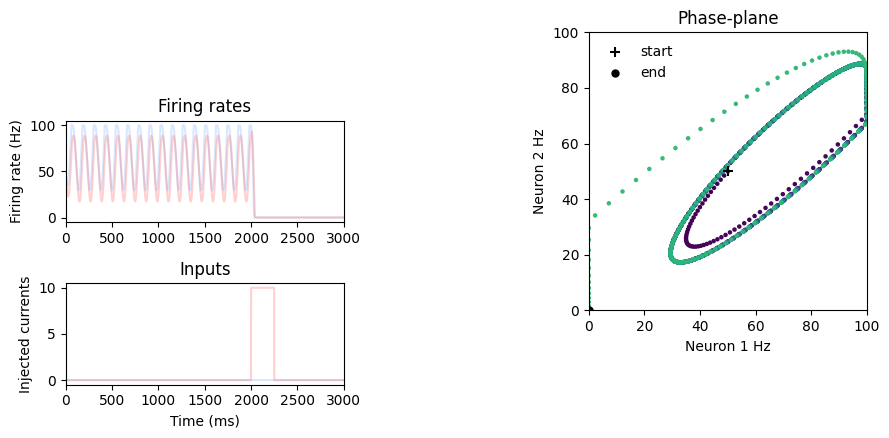

In [ ]:
# Potentially useful examples of recurrent weights affecting dynamics

import numpy as np
import matplotlib.pyplot as plt

# ---------- Parameter sets (from your MATLAB) ----------
single = {
    "I_y": np.array([-10, -10]),
    "I_t1": np.array([0, 20]),
    "I_t2": np.array([20, 0]),
    "W": np.array([[-0.2, 0.8],
                   [ 0.8,-0.2]]),
    "r_init": np.array([50, 50]),
}

multi = {
    "I_y": np.array([-10, -5]),
    "I_t1": np.array([0, 20]),
    "I_t2": np.array([-20, 0]),
    "W": np.array([[ 1.1,-0.15],
                   [-0.15, 1.1]]),
    "r_init": np.array([50, 50]),
}

continuous = {
    "I_y": np.array([-10, -10]),
    "I_t1": np.array([0.5, 0.0]),
    "I_t2": np.array([0.5, 0.0]),
    "W": np.array([[ 0.8,-0.2],
                   [-0.2, 0.8]]),
    "r_init": np.array([50, 50]),
}

oscillator = {
    "I_y": np.array([ 8, 20]),
    "I_t1": np.array([0, 0]),
    "I_t2": np.array([0,10]),
    "W": np.array([[ 2.2,-1.3],
                   [ 1.2,-0.1]]),
    "r_init": np.array([50, 50]),
}

# --------- choose your configuration (match MATLAB: p = continuous) ----------
p = oscillator  # or: single, multi, oscillator

# ---------- Simulation settings (match MATLAB) ----------
dt = 1              # ms
t_max = 3000        # ms
duration = 250      # ms (length of each stimulation)
t1 = 1000           # ms
t2 = 2000           # ms
dt_tau = 0.1        # Euler ratio for 1 ms step and tau = 10 ms

# ---------- Build inputs over time (shape: T+1 by 2) ----------
T = int(t_max / dt)
times = np.arange(0, T + 1)  # 0..3000 inclusive -> 3001 samples
inputs = np.zeros((T + 1, 2))

idx1 = int(t1 / dt)
idx2 = int(t2 / dt)
dur = int(duration / dt)

inputs[idx1:idx1 + dur, :] = p["I_t1"]
inputs[idx2:idx2 + dur, :] = p["I_t2"]

# ---------- Fire-rate simulation (two units, linear-threshold with clipping) ----------
N = np.zeros((T + 1, 2))
N[0, :] = p["r_init"]

W = p["W"]
I_y = p["I_y"]

for k in range(T):  # update N[k+1] from N[k]
    # neuron 1
    N[k+1, 0] = N[k, 0] + dt_tau * (-N[k, 0] + W[0, :] @ N[k, :] + inputs[k, 0] - I_y[0])
    # neuron 2
    N[k+1, 1] = N[k, 1] + dt_tau * (-N[k, 1] + W[1, :] @ N[k, :] + inputs[k, 1] - I_y[1])

    # rectify to [0, 100] Hz
    N[k+1, :] = np.clip(N[k+1, :], 0.0, 100.0)

# ---------- Dynamics classification (same formulas as your MATLAB snippet) ----------
trace = -2 + W[0,0] + W[1,1]
det = (-1 + W[0,0]) * (-1 + W[1,1]) - W[0,1] * W[1,0]

stability = "unstable" if trace > 0 else "stable"
node_or_focus = "node" if trace**2 > 4 * det else "focus"

print(f"trace = {trace:.3f}")
print(f"det   = {det:.3f}")
print(f"Stability: {stability}")
print(f"Type: {node_or_focus}")

# ---------- Plot (3 panels similar to MATLAB layout) ----------
n1_colour = (0.5, 0.7, 1.0, 0.3)
n2_colour = (1.0, 0.4, 0.4, 0.3)

fig = plt.figure(figsize=(9, 5))
gs = fig.add_gridspec(3, 5)

# Firing rates over time: subplot(3,5,[6 7]) -> row=1, cols=0:2
ax_rates = fig.add_subplot(gs[1, 0:2])
ax_rates.plot(times, N[:, 0], color=n1_colour)
ax_rates.plot(times, N[:, 1], color=n2_colour)
ax_rates.set_xlim(0, T)
ax_rates.set_ylabel("Firing rate (Hz)")
ax_rates.set_title("Firing rates")

# Inputs over time: subplot(3,5,[11 12]) -> row=2, cols=0:2
ax_inputs = fig.add_subplot(gs[2, 0:2])
ax_inputs.plot(times, inputs[:, 0], color=n1_colour)
ax_inputs.plot(times, inputs[:, 1], color=n2_colour)
ax_inputs.set_xlim(0, T)
ax_inputs.set_ylabel("Injected currents")
ax_inputs.set_xlabel("Time (ms)")
ax_inputs.set_title("Inputs")

# Phase-plane: subplot(3,5,[4 5 9 10 14 15]) -> all rows, cols=3:5 (right block)
ax_phase = fig.add_subplot(gs[:, 3:5])
c = np.linspace(1, 10, N.shape[0])
ax_phase.scatter(N[:, 0], N[:, 1], s=5, c=c)
ax_phase.scatter(N[0, 0], N[0, 1], s=50, c='k', marker='+', label='start')
ax_phase.scatter(N[-1, 0], N[-1, 1], s=25, c='k', label='end')
ax_phase.set_xlim(0, 100)
ax_phase.set_ylim(0, 100)
ax_phase.set_xlabel("Neuron 1 Hz")
ax_phase.set_ylabel("Neuron 2 Hz")
ax_phase.set_aspect('equal', adjustable='box')
ax_phase.set_title("Phase-plane")
ax_phase.legend(loc="best", frameon=False)

plt.tight_layout()
plt.show()


# Fitting to behaviour

We have behavioral data from a two-armed-bandit reversal task.

Mice are presented with two cue lights (A and B) and need to make a choice. Probabilities for rewards are 0.75 ('good poke') for one state and 0.25 on the other (not 'good poke'), a state which reverses randomly. However, occasionally only one light goes on (A or B) and the mouse must make their next poke there to continue the task, so this is considered 'forced_choice'.

Let's load some data:



In [ ]:
DATA_PATH = Path('./NM_TinyRNN/data/')
TASK = 'AB_behaviour'

subject_data = []
for subject_dir in (DATA_PATH/TASK).iterdir():
  if subject_dir.is_dir(): #skip the README file
    for session_dir in subject_dir.iterdir():
      if 'WS16' in session_dir.stem: #theres duplicate data with weird names/skip this
        continue
      if session_dir.is_dir(): #skip the .DS_session stuff
        subject_data.append(pd.read_csv(session_dir/'trials.htsv', sep = '\t'))
subject_df = pd.concat(subject_data) #concatenate across sessions here (that's ok)

subject_df

,forced_choice,choice,outcome
0,False,poke_4,True
1,False,poke_4,True
2,True,poke_6,False
3,False,poke_4,True
4,True,poke_6,False
...,...,...,...
344,True,poke_4,False
345,False,poke_6,True
346,False,poke_4,False
347,False,poke_6,False


In [277]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pathlib import Path

class AB_Dataset(Dataset):
    def __init__(self, subject_data_path, sequence_length):
        self.subject_data_path = Path(subject_data_path)
        self.sequence_length = sequence_length
        self.subject_df = self._load_and_concat_data()
        self.inputs, self.targets = self._create_sequences()

    def _load_and_concat_data(self):
        subject_data = []
        for session_dir in self.subject_data_path.iterdir():
            if 'WS16' in session_dir.stem:
                continue
            if session_dir.is_dir():
                subject_data.append(pd.read_csv(session_dir/'trials.htsv', sep = '\t'))
        return pd.concat(subject_data)

    def _create_sequences(self):
        # Convert boolean and categorical columns to numerical
        df_processed = self.subject_df.copy()
        df_processed['forced_choice'] = df_processed['forced_choice'].astype(int)
        df_processed['outcome'] = df_processed['outcome'].astype(int)
        df_processed['choice'] = df_processed['choice'].astype('category').cat.codes

        # Convert to tensor and handle potential remainder
        data_tensor = torch.tensor(df_processed[['forced_choice', 'outcome', 'choice']].values, dtype=torch.float32)
        num_rows = data_tensor.size(0)
        remainder = num_rows % self.sequence_length
        if remainder != 0:
            data_tensor = data_tensor[:-remainder] # Trim off the remainder

        # Reshape into sequences
        num_sequences = data_tensor.size(0) // self.sequence_length
        sequences = data_tensor.view(num_sequences, self.sequence_length, data_tensor.size(1))

        # Create inputs and targets
        # Inputs are 'forced_choice' and 'outcome' at time t
        inputs = sequences[:, :-1, :]
        # Targets are 'choice' at time t+1, one-hot encoded
        targets_codes = sequences[:, 1:, 2].long() # Get the categorical codes as long tensor
        targets = torch.nn.functional.one_hot(targets_codes, num_classes=2).float() # One-hot encode


        return inputs, targets


    def __len__(self):
        return self.inputs.size(0)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Example usage:
# Define the data path and sequence length
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'
SEQUENCE_LENGTH = 150+1 # Define your desired sequence length

# Create the dataset and dataloader
dataset = AB_Dataset(DATA_PATH, SEQUENCE_LENGTH)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Example of iterating through the dataloader
# for batch_inputs, batch_targets in dataloader:
#      print("Inputs shape:", batch_inputs.shape)
#      print("Targets shape:", batch_targets.shape)
#      break # Just printing the first batch shapes for demonstration

In [278]:
dataset.targets.shape

torch.Size([28, 150, 2])

In [311]:
# Create a flexible way of training different RNNs to do the task prediction

class TinyRNN(nn.Module):
  def __init__(self, input_size:int=3, hidden_size:int=1, out_size:int=2,
               model_type = 'GRU',
               sparsity_lambda:float = 1e-2):
    super().__init__()
    self.I = input_size
    self.H = hidden_size
    self.O = out_size
    if model_type == 'GRU':
      self.rnn = ManualGRU(self.I,self.H)
    elif model_type == 'LSTM':
      self.rnn = ManualLSTM(self.I,self.H)
    elif model_type == 'NMRNN':
      self.rnn = ManualNMRNN(self.I,self.H)
    self.decoder = nn.Linear(self.H, self.O)
    self.L1 = sparsity_lambda

  def forward(self, inputs):
    hidden, _ = self.rnn(inputs)
    predictions = self.decoder(hidden)
    return predictions

  def compute_losses(self, predictions, targets):
    prediction_loss = nn.functional.cross_entropy(predictions, targets) #NB: this applies softmax itself
    #for sparsity we need to select the right weights to regularise
    sparsity_loss = 0
    for name, param in self.rnn.named_parameters():
      if 'bias' not in name:
        sparsity_loss += self.L1*torch.abs(param).sum()
    return prediction_loss, sparsity_loss




In [312]:
# Create model, optimizer, and loss function

from tqdm import tqdm

SPARSITY_LAMBDA = 1e-5
LEARNING_RATE = 0.005
model = TinyRNN(input_size=3, hidden_size=2, out_size=2, model_type='GRU', sparsity_lambda = SPARSITY_LAMBDA) # Example sizes
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
num_epochs = 100 # Example number of epochs
prediction_losses = []
sparsity_losses = []
for epoch in tqdm(range(num_epochs)):
    total_loss = 0
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        predictions= model(batch_inputs)

        # Compute loss
        # The targets are already one-hot encoded, so we use cross_entropy
        # We need to flatten the predictions and targets for cross_entropy
        prediction_loss, sparsity_loss = model.compute_losses(predictions.view(-1, model.O), batch_targets.view(-1, model.O))
        loss = prediction_loss + sparsity_loss # Combine losses

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        prediction_losses.append(prediction_loss.item())
        sparsity_losses.append(sparsity_loss.item())

print("Training finished.")

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: shape '[8, 2]' is invalid for input of size 8

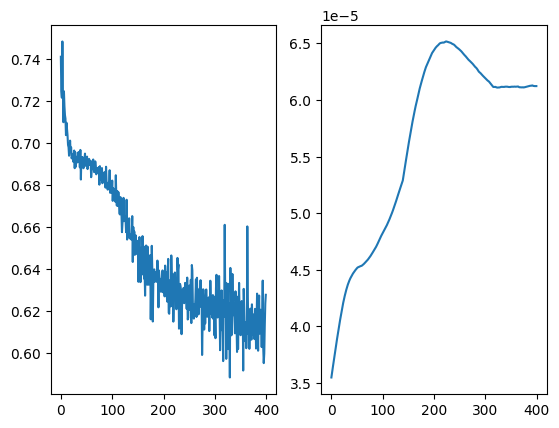

In [307]:
fig, ax = plt.subplots(1,2)
ax[0].plot(prediction_losses)
ax[1].plot(sparsity_losses)

In [308]:
model.rnn.get_

tensor([[[0.5009, 0.4991],
         [0.5469, 0.4531],
         [0.3926, 0.6074],
         ...,
         [0.5349, 0.4651],
         [0.4698, 0.5302],
         [0.6514, 0.3486]],

        [[0.3323, 0.6677],
         [0.3009, 0.6991],
         [0.2600, 0.7400],
         ...,
         [0.7492, 0.2508],
         [0.7301, 0.2699],
         [0.7425, 0.2575]],

        [[0.3874, 0.6126],
         [0.3459, 0.6541],
         [0.4312, 0.5688],
         ...,
         [0.5415, 0.4585],
         [0.6760, 0.3240],
         [0.6740, 0.3260]],

        [[0.6402, 0.3598],
         [0.7098, 0.2902],
         [0.6519, 0.3481],
         ...,
         [0.4950, 0.5050],
         [0.5147, 0.4853],
         [0.5570, 0.4430]]], grad_fn=<SoftmaxBackward0>)

In [247]:
for name, param in model.rnn.named_parameters():
  if 'bias' not in name:
    print(name, param.shape)

W_from_in torch.Size([3, 3])
W_from_h torch.Size([1, 3])


In [249]:
test = torch.nn.LSTM(1,2)
for test, param in test.named_parameters():
  print(test, param.shape)

weight_ih_l0 torch.Size([8, 1])
weight_hh_l0 torch.Size([8, 2])
bias_ih_l0 torch.Size([8])
bias_hh_l0 torch.Size([8])
